
# TFM - Modelos de Propensión para Campañas Comerciales

**Autor:** Grupo 4

---

## 1. Carga de librerías


In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler



---

## 2. Carga del dataset y aplicar buenas prácticas


In [39]:
# 1. Cargar y preprocesar los datos
df = pd.read_csv("./Data/customer_shopping_data_v4.csv", delimiter=';')

In [40]:
#Una vez cargado el dataset, lo primero vamos a ver si hay valores nulos y si existen filas duplicadas
print(df.isnull().sum())

print("-------------")
print("Número de filas duplicadas: ", df.duplicated().sum())

Factura             0
ID_Cliente          0
Categoría           0
Cantidad            0
Importe             0
Método de Pago      0
Fecha_Factura       0
Centro_Comercial    0
Canal               0
Género              0
Edad                0
Zona                0
Segmentación        0
dtype: int64
-------------
Número de filas duplicadas:  0


#### Parece que no existen ni valores nulos ni filas duplicadas en nuestro dataset, por tanto, para este caso no será necesario realizar nada más

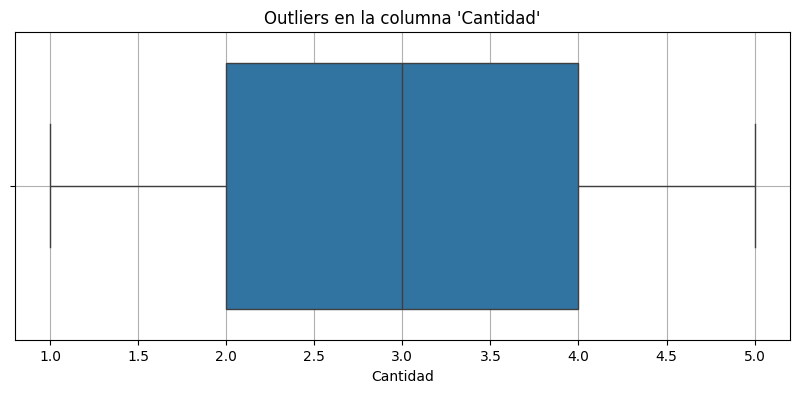

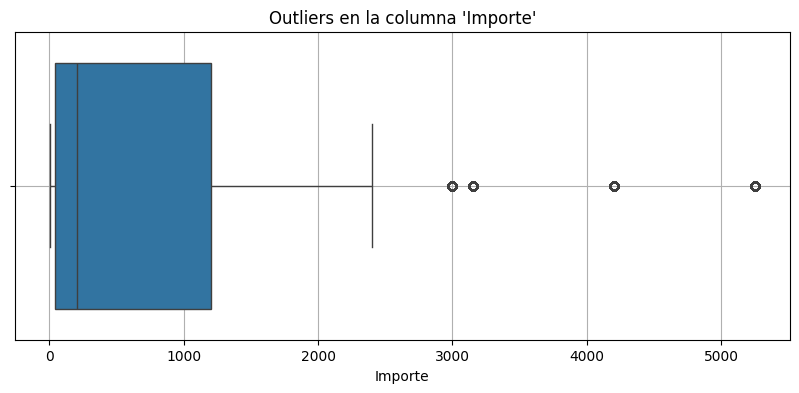

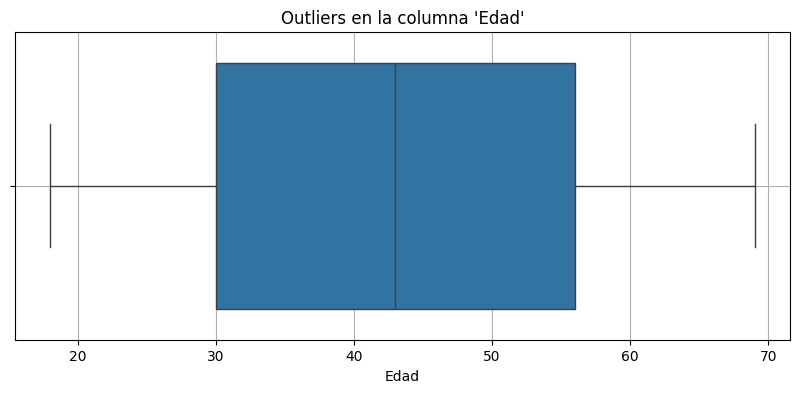

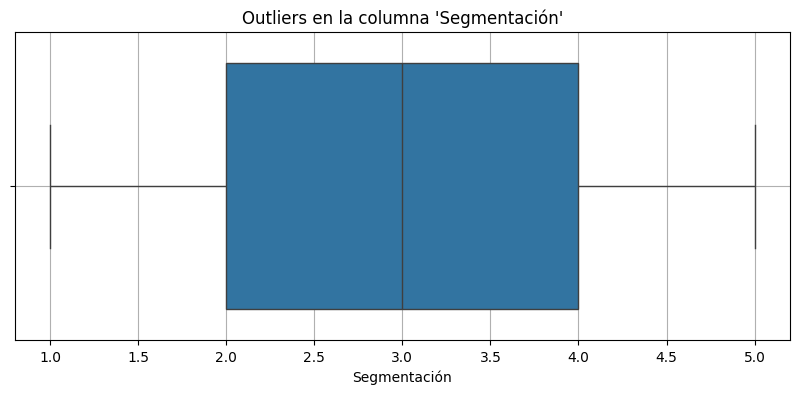

In [41]:
#Visualizamos los outliers para cada columna numérica

for columna in df.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[columna])
    plt.title(f"Outliers en la columna '{columna}'")
    plt.grid(True)
    plt.show()


In [42]:
#Vamos a crear una funcion que nos diga exactamente cuales son los outliers de una columna
def detectar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    return outliers

In [43]:
# Vamos a ver cuales son los registros outliers de Importe, ya que viendo las gráficas es en la única columna donde existen outilers, osea valores que se alejan de los valores "normales"
# que serían los datos que están entre el Q1 y el Q3
# outliers_importe = detectar_outliers(df, "Purchase Amount (USD)")

# # Mostrar los outliers
# print(outliers_importe)
df.head()

,Factura,ID_Cliente,Categoría,Cantidad,Importe,Método de Pago,Fecha_Factura,Centro_Comercial,Canal,Género,Edad,Zona,Segmentación
0,I000001,C241288,Moda,5,1500.40,Otras Tarjetas,05/08/2022,Castellana,Tienda física,Femenino,28,Centro,1
1,I000002,C111565,Zapatería,3,1800.51,Tarjeta ECI,12/12/2021,Marbella,Tienda física,Masculino,21,Sur,5
2,I000003,C266599,Moda,1,300.08,Efectivo,09/11/2021,Plaza Catalunya,Tienda física,Masculino,20,Norte,5
3,I000004,C988172,Zapatería,5,3000.85,Otras Tarjetas,16/05/2021,Goya,Tienda física,Femenino,66,Centro,5
4,I000005,C189076,Libros,4,60.60,Efectivo,24/10/2021,Castellana,Tienda física,Femenino,53,Centro,2


##### Aunque tengamos outliers en el importe, los vamos a conservar ya que vamos a aplicar un modelo RandomForest, el cual es robusto a outliers y además el que existan clientes con un importe tan alto es bueno para nuestro propósito que es segmentar a los clientes por sus gastos y frecuencia de compra, para después aplicarlo a campañas comerciales.

In [44]:
#Asegurar formatos, sobretodo para el campo fecha, vamos a asegurarnos que tiene el formato requerido
df['Fecha_Factura'] = pd.to_datetime(df['Fecha_Factura'], format="%d/%m/%Y")
df['Factura'] = df['Factura'].astype(str)
 

In [45]:
#Una vez analizados y limpiados los datos, vamos a realizar una agrupación de los clientes, ya que en nuestro dataset tenemos
# registros con igual cliente pero en el que los demás datos son diferentes

today = df['Fecha_Factura'].max()
 
#Vamos a calcular:
# Importe:
#   - El importe total del cliente
#   - El importe medio por compra.
# Factura:
#   - Contaremos el número de facturas que tiene el cliente para obtener la frecuencia de compra
#   - Obtendremos el número de días que han pasado desde la última factura
# Categoría:
#   - Nos quedamos con la categorías más frecuente
#Lo mismo hacemos para Canal y Metodo de pago

cliente_df = df.groupby('ID_Cliente').agg({
    'Importe': ['sum', 'mean'],
    'Factura': 'count',
    'Fecha_Factura': lambda x: (today - x.max()).days,
    'Categoría': lambda x: x.mode()[0],
    'Canal': lambda x: x.mode()[0],
    'Edad': 'first',
    'Método de Pago': lambda x: x.mode()[0],
    'Género': 'first'
})
cliente_df.head()

Importe          Factura Fecha_Factura     Categoría  \
                sum     mean   count      <lambda>      <lambda>   
ID_Cliente                                                         
C100004     6001.60  1500.40       4           711          Moda   
C100005     2400.68  1200.34       2           110     Zapatería   
C100006      537.60   107.52       5           254    Juguetería   
C100012      156.90    26.15       6           200  Supermercado   
C100019       71.68    35.84       2           634    Juguetería   

                    Canal  Edad  Método de Pago     Género  
                 <lambda> first        <lambda>      first  
ID_Cliente                                                  
C100004     Tienda física    61  Otras Tarjetas  Masculino  
C100005     Tienda física    34        Efectivo  Masculino  
C100006     Tienda física    44  Otras Tarjetas  Masculino  
C100012     Tienda física    25        Efectivo  Masculino  
C100019     Tienda física    21  Otras Tarjetas   Femenino

In [46]:
#Renombramos las columnas
cliente_df.columns = ['Importe_total', 'Ticket_medio', 'Frecuencia', 'Dias_desde_ultima_factura', 'Categoria_top', 'Canal_preferido', 'Edad', 'Metodo_pago', 'Genero']
cliente_df.reset_index(inplace=True)
cliente_df.head()

,ID_Cliente,Importe_total,Ticket_medio,Frecuencia,Dias_desde_ultima_factura,Categoria_top,Canal_preferido,Edad,Metodo_pago,Genero
0,C100004,6001.60,1500.40,4,711,Moda,Tienda física,61,Otras Tarjetas,Masculino
1,C100005,2400.68,1200.34,2,110,Zapatería,Tienda física,34,Efectivo,Masculino
2,C100006,537.60,107.52,5,254,Juguetería,Tienda física,44,Otras Tarjetas,Masculino
3,C100012,156.90,26.15,6,200,Supermercado,Tienda física,25,Efectivo,Masculino
4,C100019,71.68,35.84,2,634,Juguetería,Tienda física,21,Otras Tarjetas,Femenino


In [47]:
#Vamos a obtener la columna Segmento Economico para clasificar a los clientes en 5 categorías, teniendo en cuenta 
# - Importe total
# - Frecuencia compra
# # - Numero dias desde la ultima compra
#Esto lo hacemos para poder crear un clasificador multilabel
# Selección y escalado de variables
le = LabelEncoder()
cliente_df['Frecuencia_encoded'] = le.fit_transform(cliente_df['Frecuencia'])
X = cliente_df[['Importe_total', 'Frecuencia_encoded']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
cliente_df['Cluster_Economico'] = kmeans.fit_predict(X_scaled)

In [48]:
cluster_summary = cliente_df.groupby('Cluster_Economico')[['Importe_total', 'Frecuencia_encoded']].mean().round(2)
print(cluster_summary)


                   Importe_total  Frecuencia_encoded
Cluster_Economico                                   
0                        7352.62                3.77
1                        1169.86                1.80
2                       19690.29                4.54
3                        1026.69                4.82


In [49]:
cluster_labels = {
    0: 'Clientes Estrella',
    1: 'Compradores de Temporada',
    2: 'Cazadores de Ofertas',
    3: 'Curiosos o Ocasionales'
}

cliente_df['Segmento_Cluster_Economico'] = cliente_df['Cluster_Economico'].map(cluster_labels)
cliente_df.head()

,ID_Cliente,Importe_total,Ticket_medio,Frecuencia,Dias_desde_ultima_factura,Categoria_top,Canal_preferido,Edad,Metodo_pago,Genero,Frecuencia_encoded,Cluster_Economico,Segmento_Cluster_Economico
0,C100004,6001.60,1500.40,4,711,Moda,Tienda física,61,Otras Tarjetas,Masculino,3,0,Clientes Estrella
1,C100005,2400.68,1200.34,2,110,Zapatería,Tienda física,34,Efectivo,Masculino,1,1,Compradores de Temporada
2,C100006,537.60,107.52,5,254,Juguetería,Tienda física,44,Otras Tarjetas,Masculino,4,3,Curiosos o Ocasionales
3,C100012,156.90,26.15,6,200,Supermercado,Tienda física,25,Efectivo,Masculino,5,3,Curiosos o Ocasionales
4,C100019,71.68,35.84,2,634,Juguetería,Tienda física,21,Otras Tarjetas,Femenino,1,1,Compradores de Temporada


In [50]:
le_cat = LabelEncoder()
cliente_df['Categoria_top'] = le_cat.fit_transform(cliente_df['Categoria_top'])

# Codificar variables categóricas predictoras
categorical_cols = ['Metodo_pago', 'Canal_preferido', 'Genero']
cliente_df = pd.get_dummies(cliente_df, columns=categorical_cols, drop_first=True)


# Separar características y variable objetivo
X_cat = cliente_df.drop(columns=['Categoria_top', 'ID_Cliente', 'Segmento_Cluster_Economico'])
y_cat = cliente_df['Categoria_top']

# Dividir en entrenamiento y prueba
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)

# Escalar características
scaler = StandardScaler()
X_train_cat = scaler.fit_transform(X_train_cat)
X_test_cat = scaler.transform(X_test_cat)

# Entrenar modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_cat, y_train_cat)

# Evaluar modelo
y_pred_cat = knn.predict(X_test_cat)
print("Precisión en test:", accuracy_score(y_test_cat, y_pred_cat))

Precisión en test: 0.4568489236044961


In [51]:
#Guardamos modelo, scaler, encoder, PCA

# Guardar modelo entrenado
joblib.dump(knn, './Modelos/Categoria/modelo_knn_cat.pkl')

# Guardar scaler
joblib.dump(scaler, './Modelos/Categoria/scaler_cat.pkl')

# Guardar LabelEncoders
joblib.dump(le_cat, './Modelos/Categoria/labelencoder_cat.pkl')

['./Modelos/Categoria/labelencoder_cat.pkl']